In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tsne import TSNE

In [3]:
tsne = TSNE()

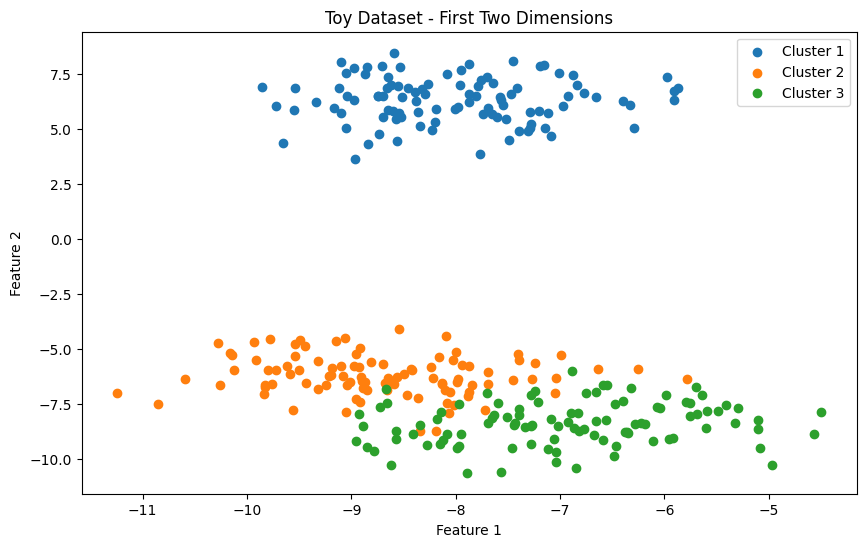

Shape of the dataset: (300, 2)
Number of labels: 3


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Create a toy dataset with 3 blobs
n_samples = 300
n_features = 2
n_centers = 3

X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_centers)

# Visualize the first two dimensions of the dataset
plt.figure(figsize=(10, 6))
for i in range(n_centers):
    plt.scatter(X[y == i, 0], X[y == i, 1], label=f'Cluster {i+1}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Toy Dataset - First Two Dimensions')
plt.legend()
plt.show()

print(f"Shape of the dataset: {X.shape}")
print(f"Number of labels: {len(np.unique(y))}")


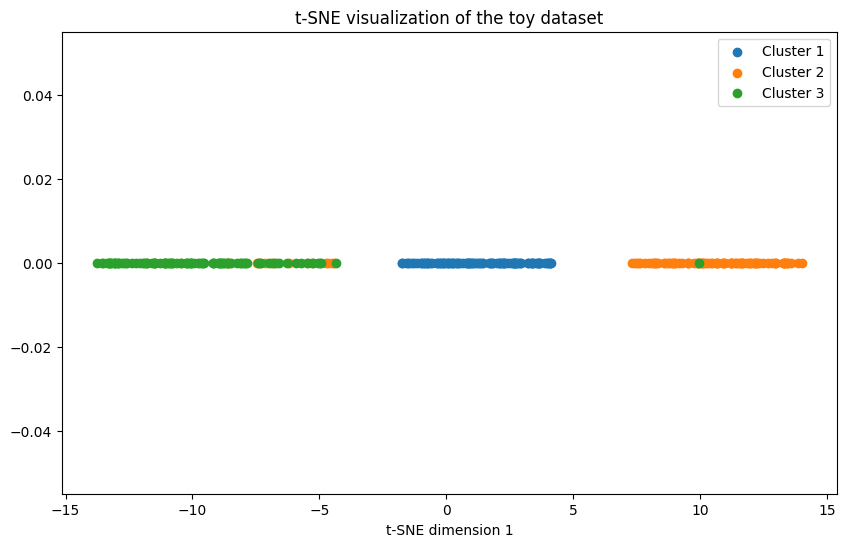

In [16]:
# Perform t-SNE on the toy dataset to 1 dimension
tsne_result = tsne.tsne(X, ydim=1, T=1000, l=200, perplexity=50)

# Visualize the t-SNE result
plt.figure(figsize=(10, 6))
plt.xlabel('t-SNE dimension 1')
plt.title('t-SNE visualization of the toy dataset')

for i in range(n_centers):
    plt.scatter(tsne_result[y == i], np.zeros_like(tsne_result[y == i]), label=f'Cluster {i+1}')
plt.legend()
plt.show()
